In [1]:
# -*- coding: utf-8 -*-

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from imageio import imread, imsave, mimsave
import glob
import os
from tqdm import tqdm

In [2]:
images = glob.glob('data/train/*.jpg')
print(len(images))

49825


In [3]:
batch_size = 1
LAMBDA = 100
WIDTH = 256
HEIGHT = 256
OUTPUT_DIR = 'samples'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

X = tf.placeholder(dtype=tf.float32, shape=[None, HEIGHT, WIDTH, 3], name='X')
Y = tf.placeholder(dtype=tf.float32, shape=[None, HEIGHT, WIDTH, 3], name='Y')
k_initializer = tf.random_normal_initializer(0, 0.02)
g_initializer = tf.random_normal_initializer(1, 0.02)

def lrelu(x, leak=0.2):
    return tf.maximum(x, leak * x)

def d_conv(inputs, filters, strides):
    padded = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT')
    return tf.layers.conv2d(padded, kernel_size=4, filters=filters, strides=strides, padding='valid', kernel_initializer=k_initializer)

def g_conv(inputs, filters):
    return tf.layers.conv2d(inputs, kernel_size=4, filters=filters, strides=2, padding='same', kernel_initializer=k_initializer)
    
def g_deconv(inputs, filters):
    return tf.layers.conv2d_transpose(inputs, kernel_size=4, filters=filters, strides=2, padding='same', kernel_initializer=k_initializer)

def batch_norm(inputs):
    return tf.layers.batch_normalization(inputs, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=g_initializer)

def sigmoid_cross_entropy_with_logits(x, y):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=y) 

In [4]:
def discriminator(x, y, reuse=None):
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.concat([x, y], axis=3)    
        h0 = lrelu(d_conv(x, 64, 2)) # 128 128 64
        
        h0 = d_conv(h0, 128, 2)
        h0 = lrelu(batch_norm(h0)) # 64 64 128
        
        h0 = d_conv(h0, 256, 2)
        h0 = lrelu(batch_norm(h0)) # 32 32 256
        
        h0 = d_conv(h0, 512, 1)
        h0 = lrelu(batch_norm(h0)) # 31 31 512
        
        logit = d_conv(h0, 1, 1) # 30 30 1
        singmoid_logit = tf.nn.sigmoid(logit) #这个就是patch gan的思想。
        
        return logit,singmoid_logit

In [5]:
def generator(x):
    with tf.variable_scope('generator', reuse=None):
        layers = []
        h0 = g_conv(x, 64)
        layers.append(h0)
        
        for filters in [128, 256, 512, 512, 512, 512, 512]:
            h0 = lrelu(layers[-1])
            h0 = g_conv(h0, filters)
            h0 = batch_norm(h0)
            layers.append(h0)
        
        encode_layers_num = len(layers) # 8
        
        for i, filters in enumerate([512, 512, 512, 512, 256, 128, 64]):
            skip_layer = encode_layers_num - i - 1
            if i == 0:
                inputs = layers[-1]
            else:
                inputs = tf.concat([layers[-1], layers[skip_layer]], axis=3)#这里是拼接上去，并不是加和
            h0 = tf.nn.relu(inputs)
            h0 = g_deconv(h0, filters)
            h0 = batch_norm(h0)
            if i < 3:
                h0 = tf.nn.dropout(h0, keep_prob=0.5)
            layers.append(h0)
        
        inputs = tf.concat([layers[-1], layers[0]], axis=3)
        h0 = tf.nn.relu(inputs)
        h0 = g_deconv(h0, 3)
        h0 = tf.nn.tanh(h0, name='g')
        return h0

In [6]:
g = generator(X)
saver = tf.train.Saver(tf.global_variables())

In [15]:
test_images = glob.glob('data/val/*.jpg')
print(len(test_images))
import matplotlib.pyplot as plt

200


INFO:tensorflow:Restoring parameters from pix2pix_diy-100000


INFO:tensorflow:Restoring parameters from pix2pix_diy-100000


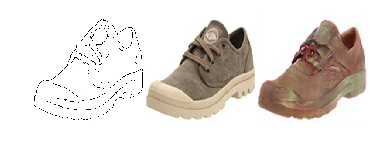

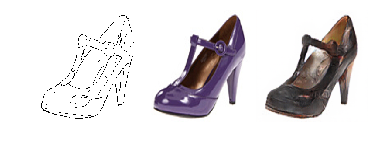

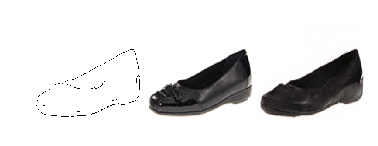

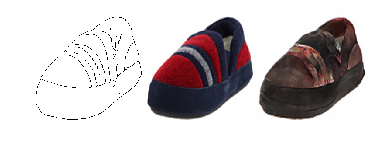

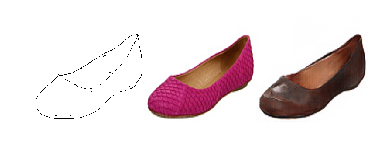

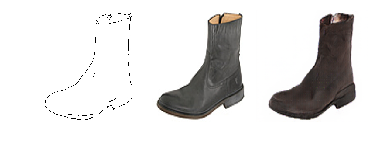

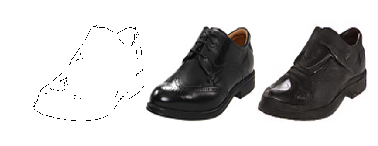

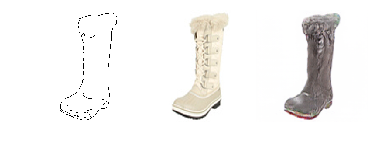

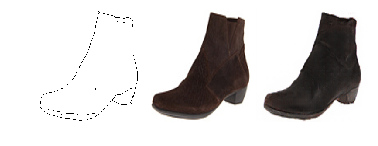

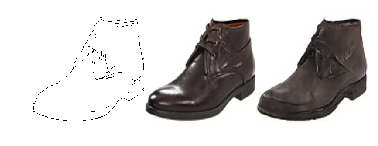

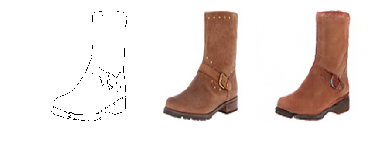

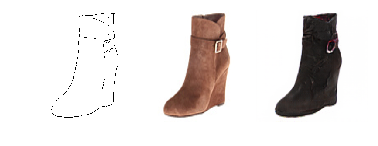

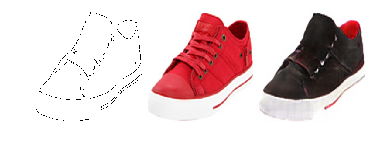

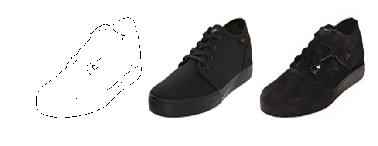

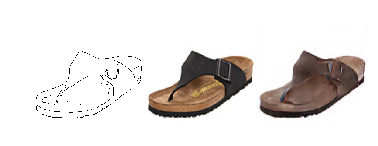

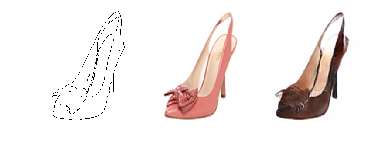

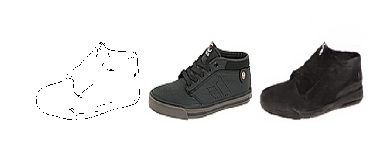

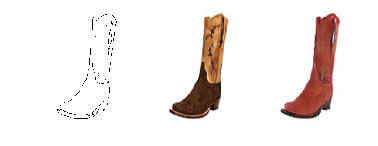

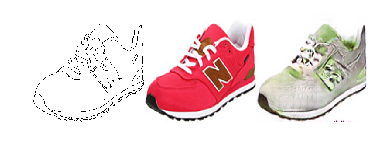

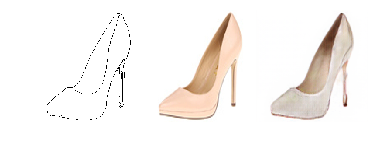

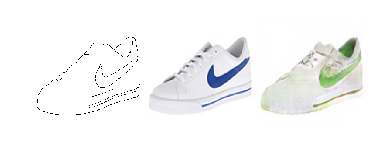

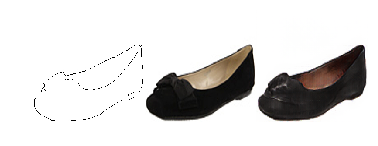

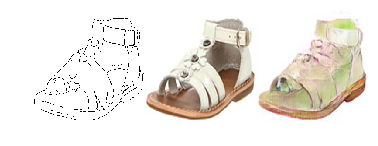

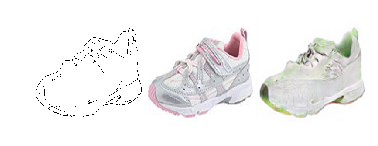

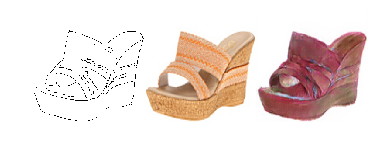

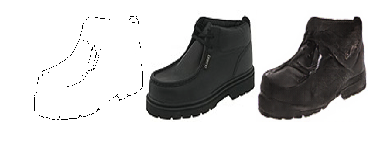

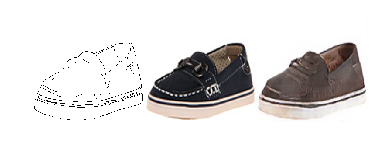

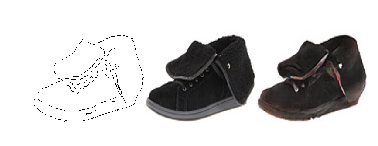

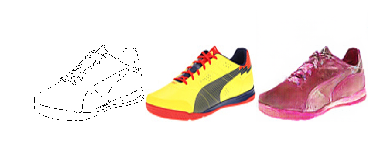

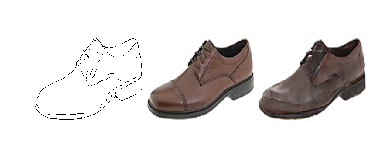

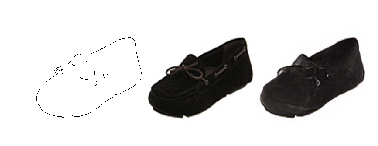

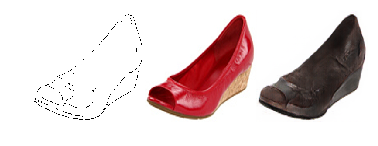

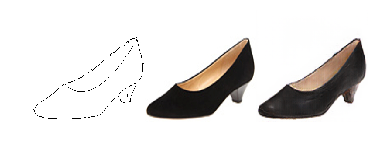

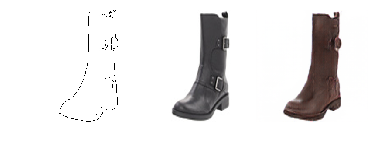

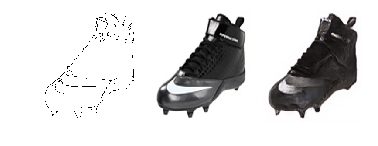

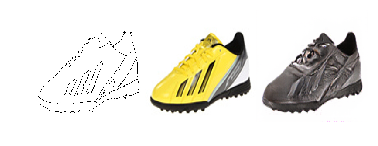

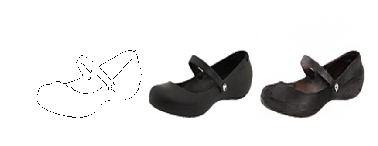

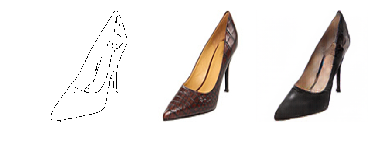

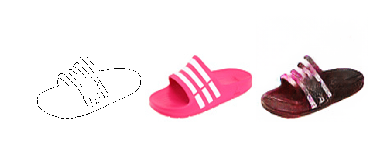

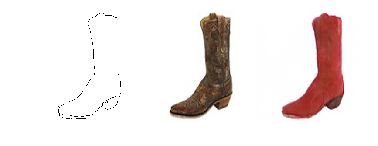

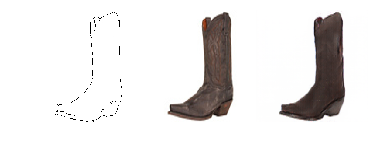

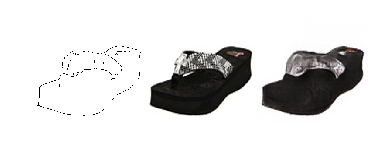

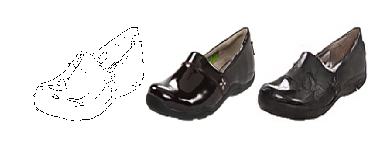

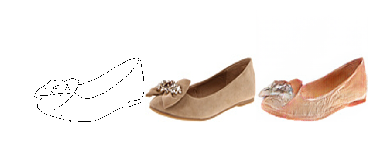

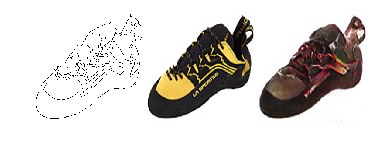

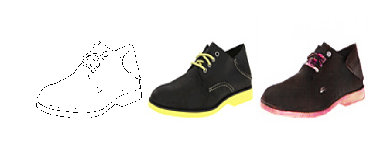

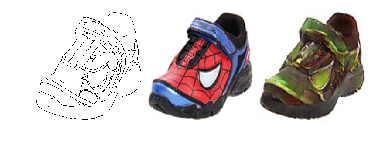

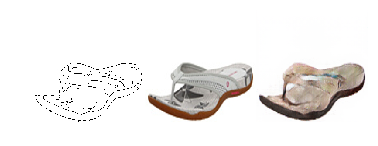

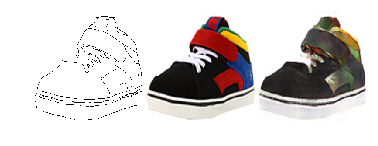

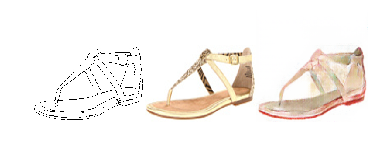

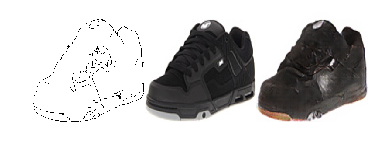

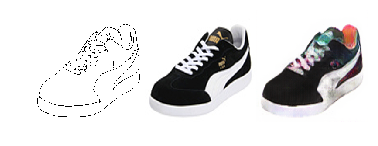

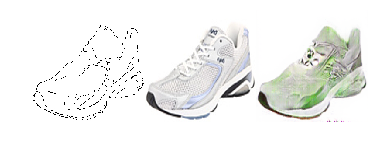

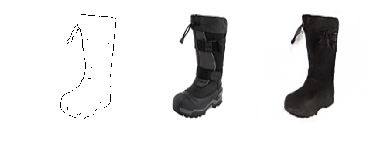

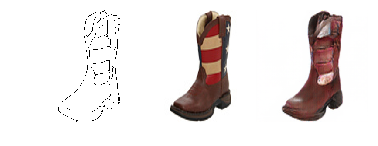

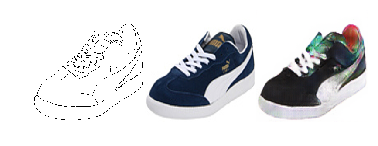

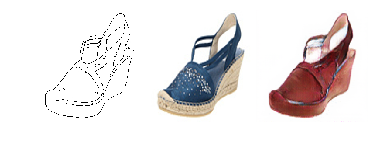

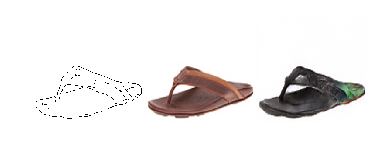

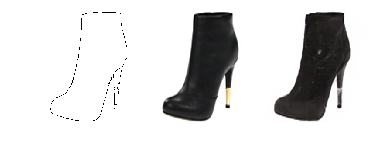

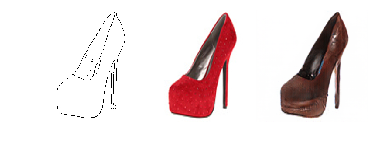

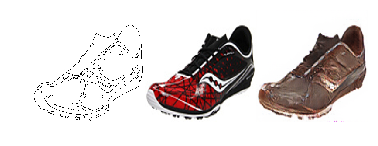

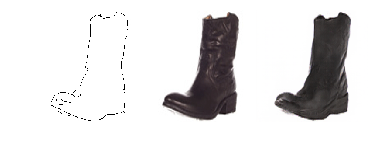

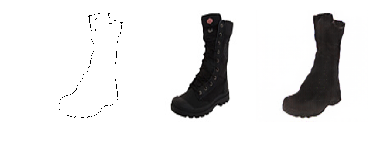

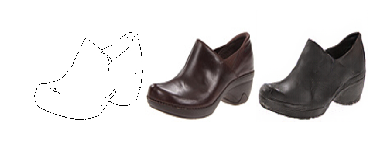

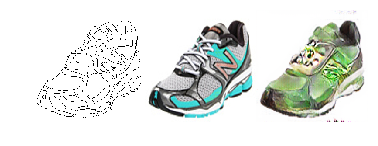

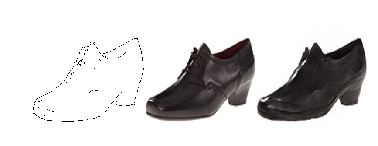

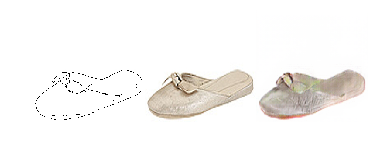

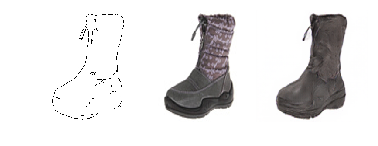

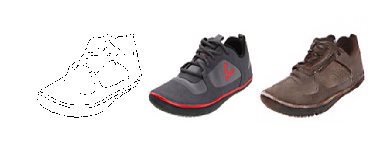

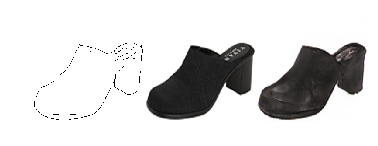

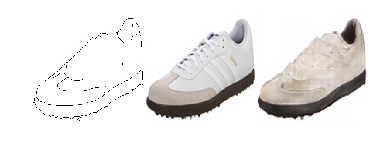

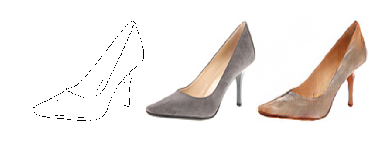

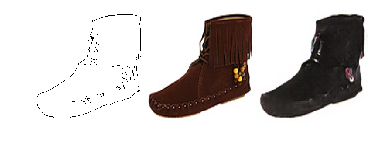

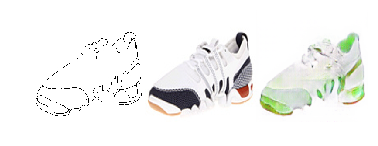

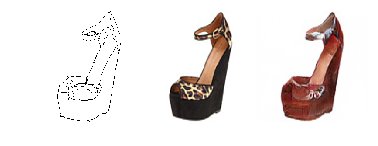

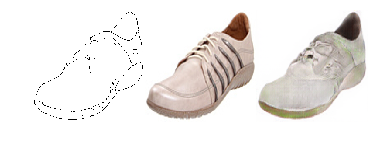

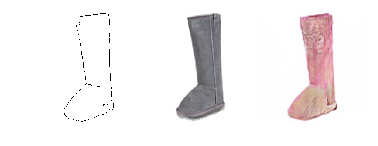

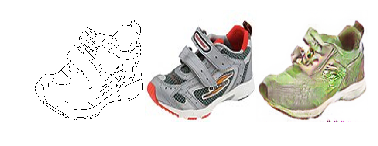

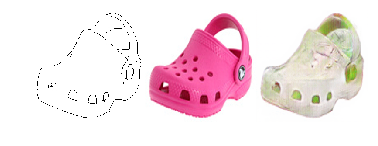

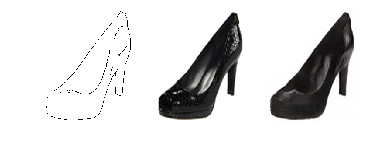

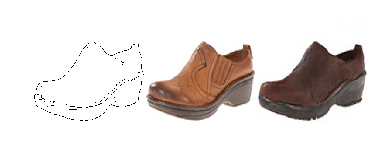

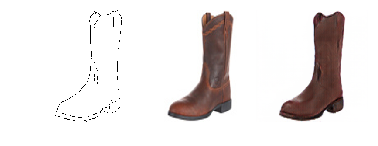

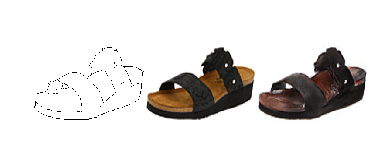

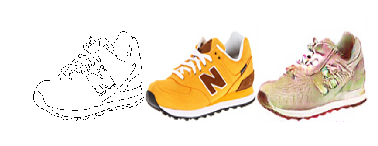

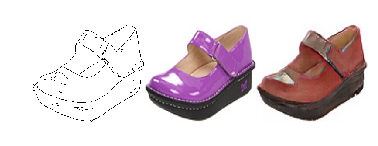

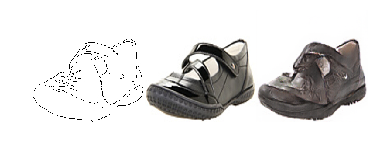

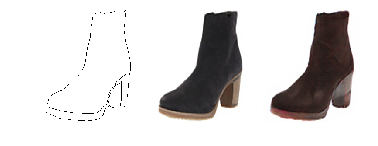

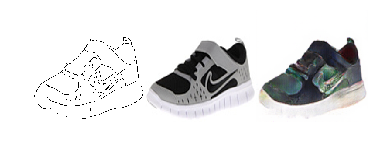

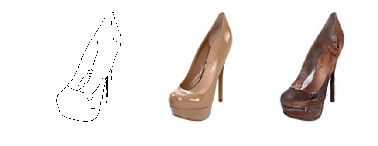

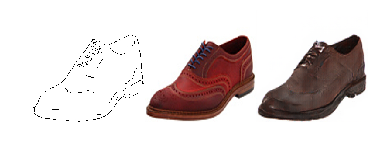

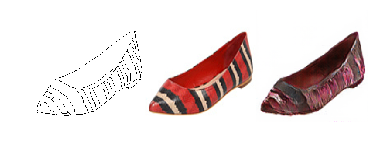

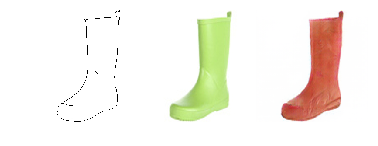

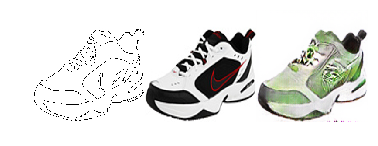

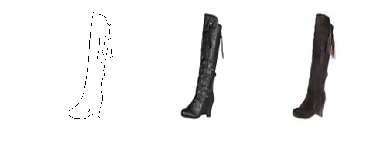

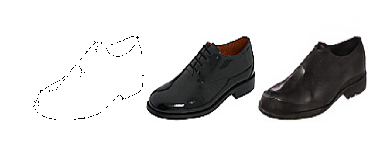

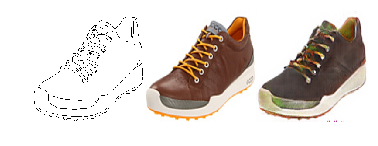

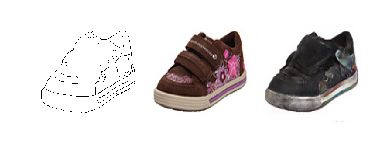

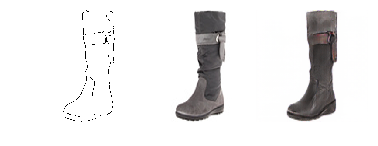

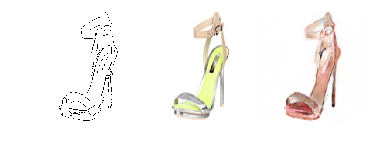

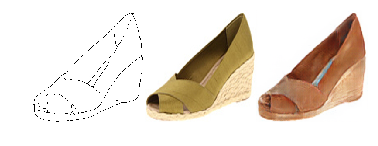

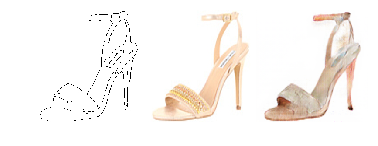

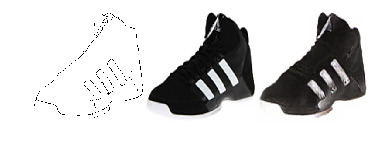

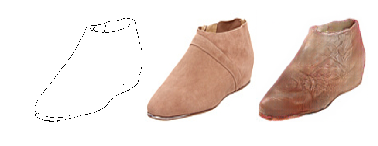

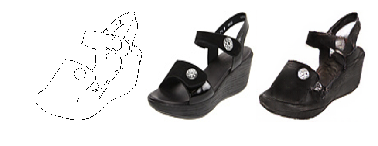

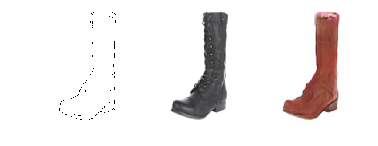

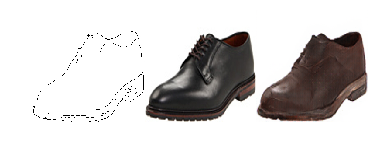

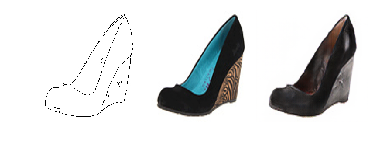

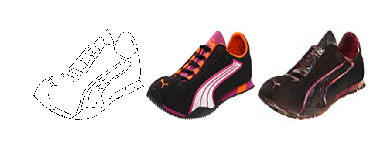

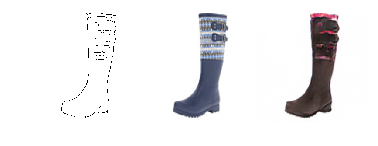

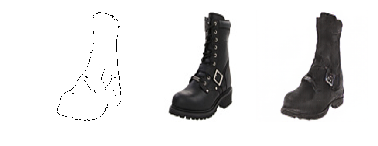

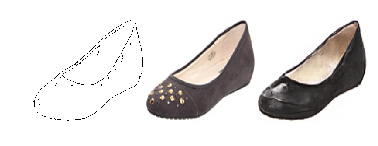

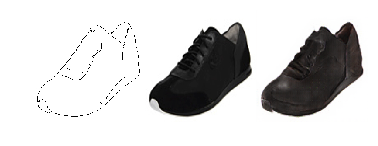

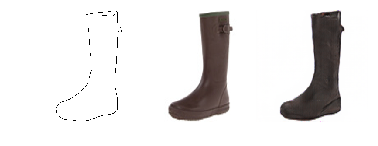

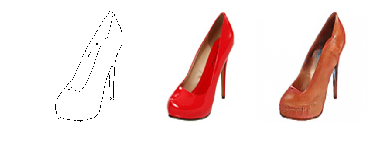

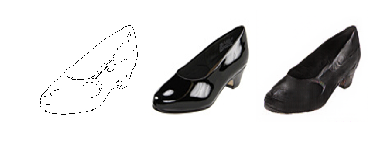

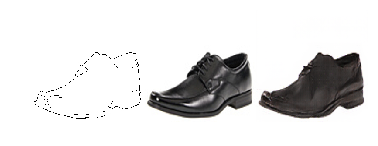

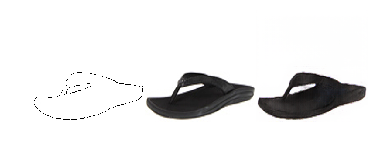

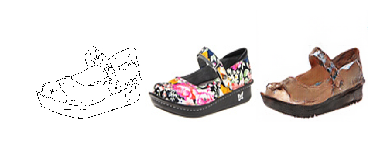

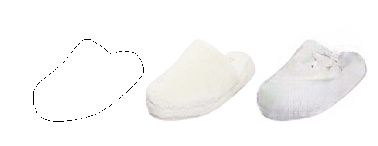

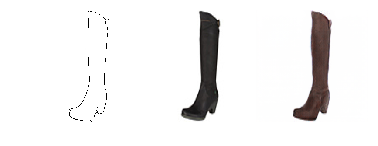

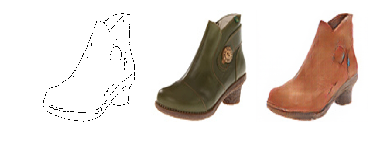

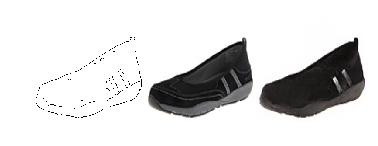

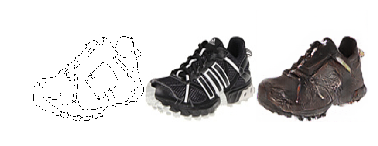

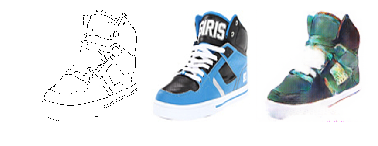

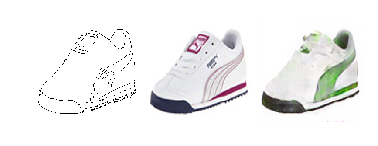

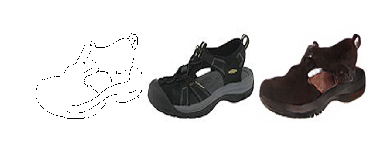

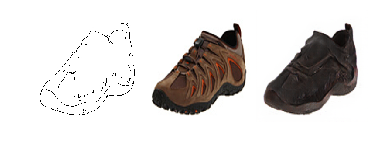

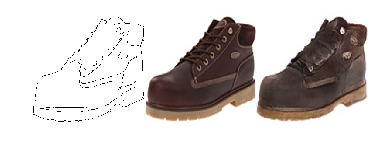

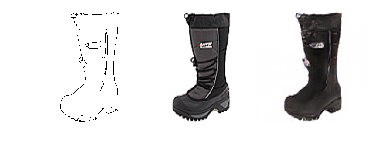

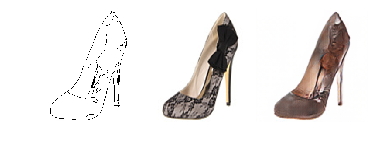

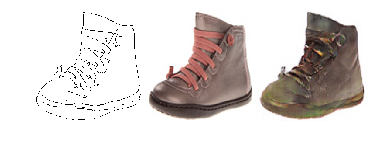

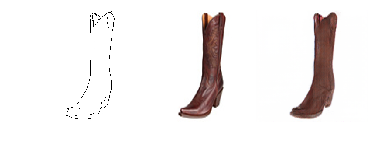

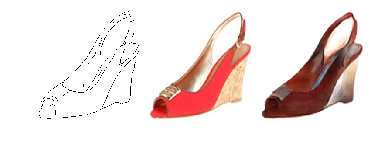

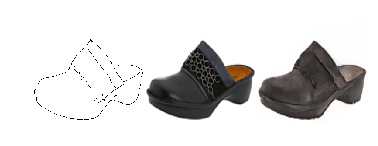

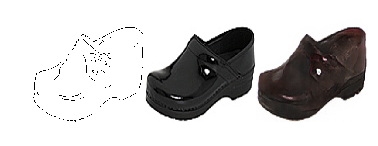

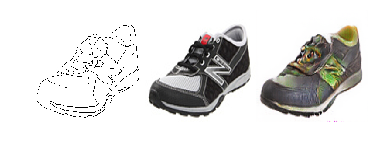

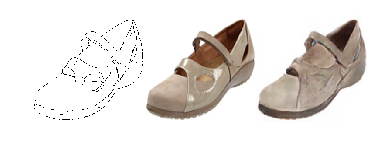

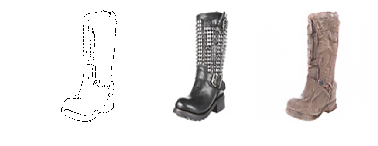

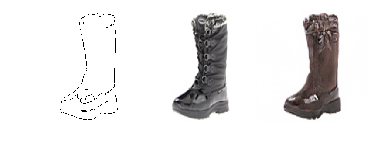

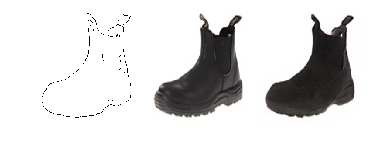

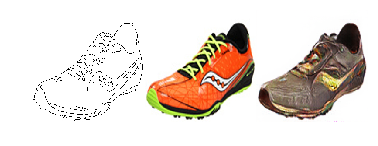

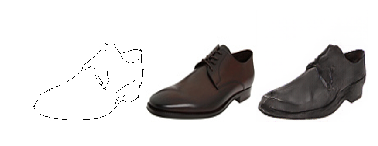

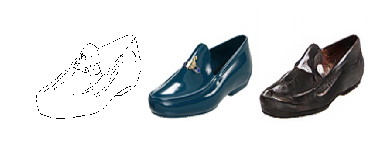

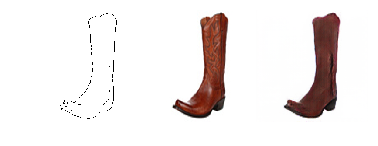

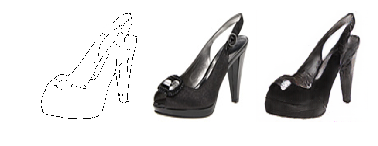

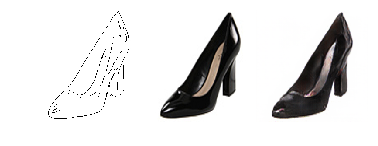

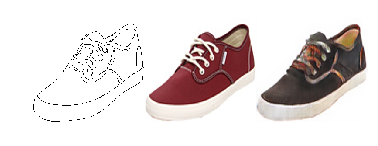

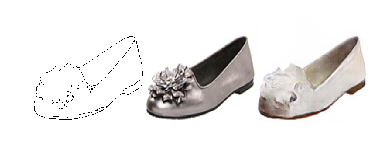

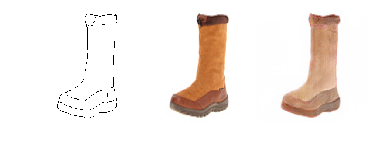

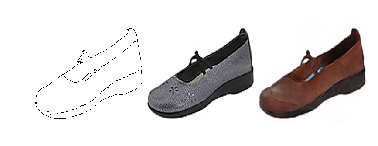

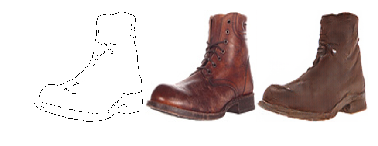

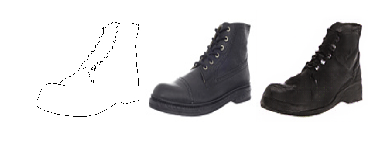

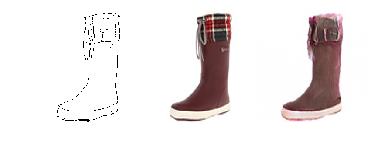

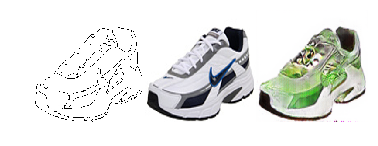

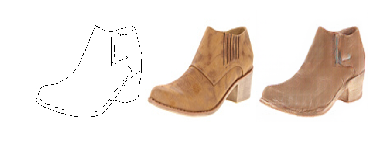

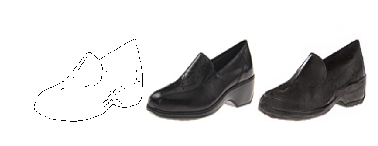

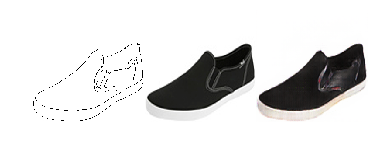

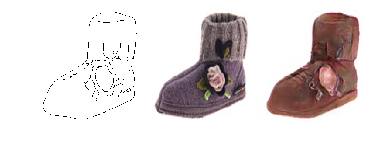

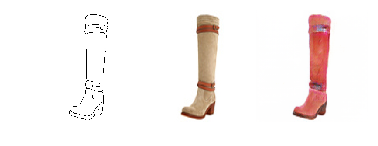

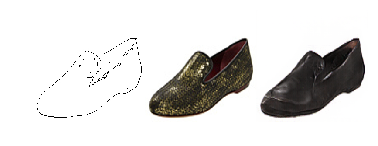

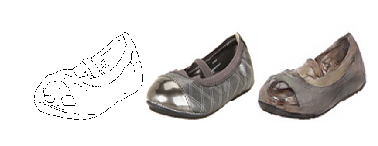

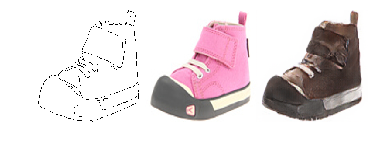

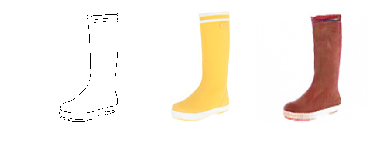

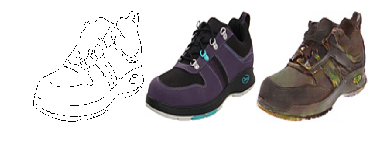

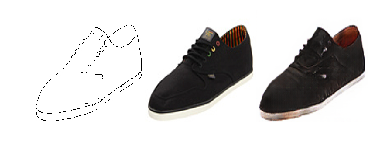

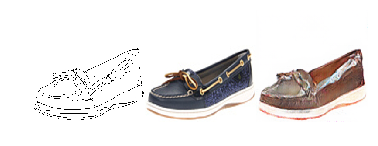

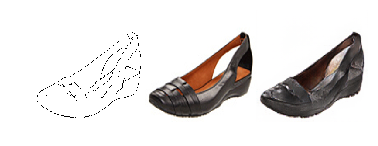

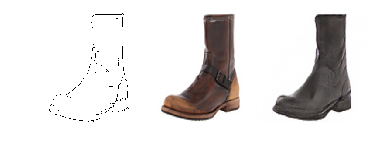

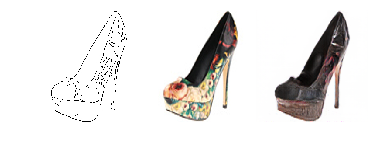

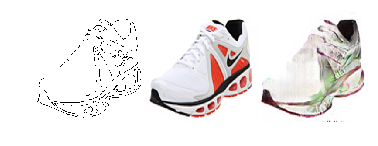

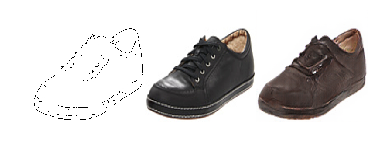

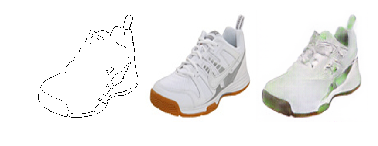

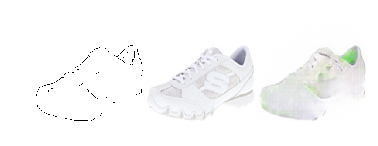

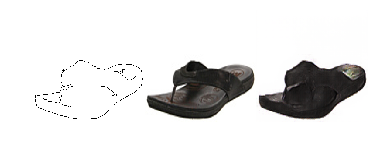

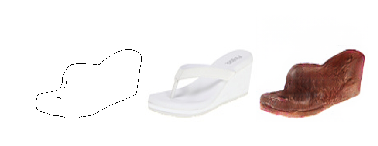

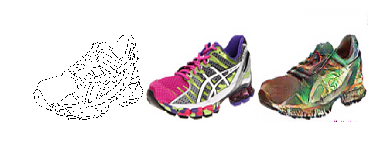

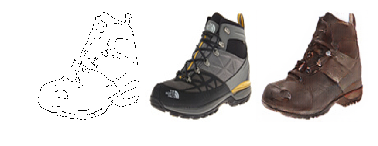

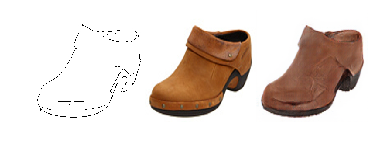

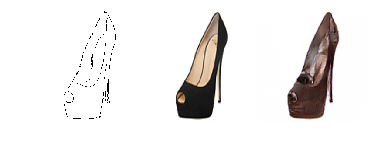

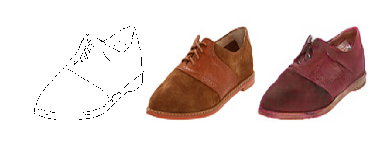

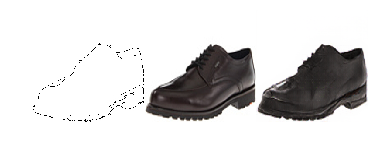

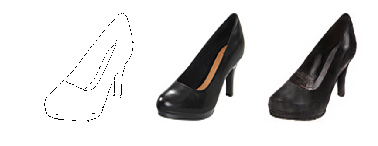

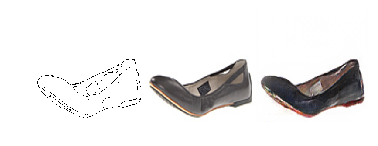

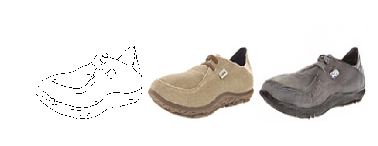

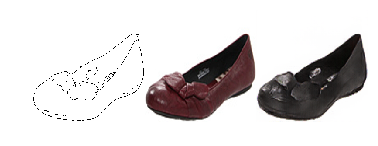

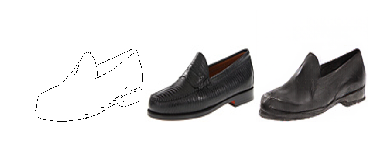

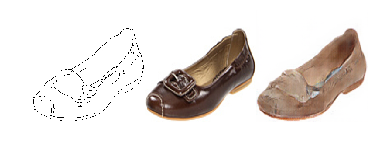

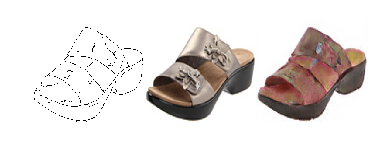

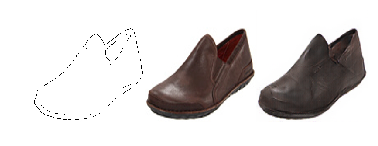

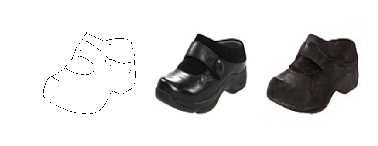

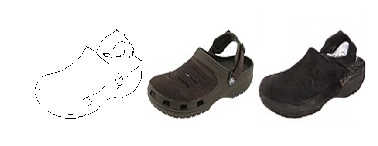

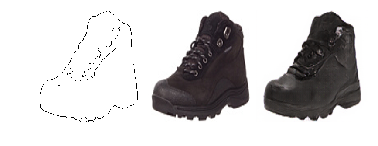

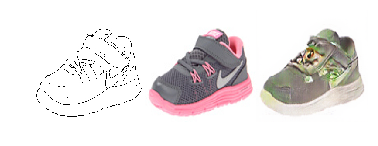

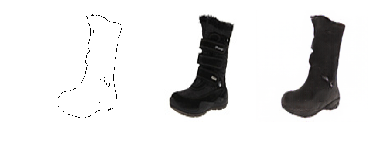

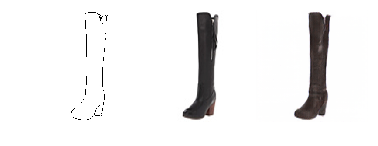

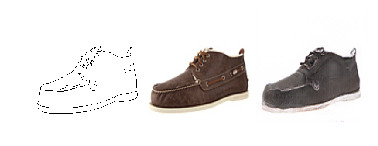

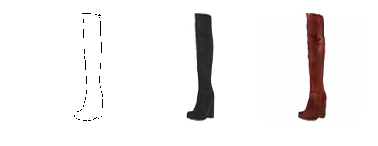

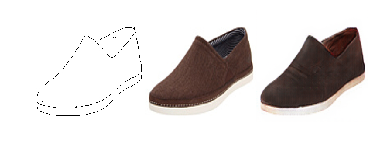

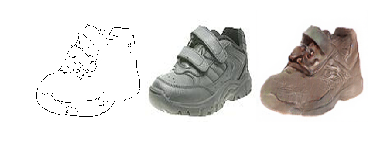

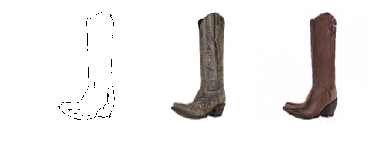

In [17]:
N = 1
with tf.Session() as sess:
    saver.restore(sess=sess,save_path='model/pix2pix_diy-100000')
    for test in test_images:
        data_img = imread(test)
        data_img = (data_img / 255. - 0.5) * 2 #这个你可以认为把数据变换到了-1到1
        label = data_img[:, WIDTH:, :]
        edge_img = data_img[:, :WIDTH, :]
        gen_imgs = sess.run(g, feed_dict={X: [edge_img]})
        result = np.zeros([N * HEIGHT, WIDTH * 3, 3])
        for i in range(N):
            result[i * HEIGHT: i * HEIGHT + HEIGHT, :WIDTH, :] = (edge_img + 1) / 2
            result[i * HEIGHT: i * HEIGHT + HEIGHT, WIDTH: 2 * WIDTH, :] = (label + 1) / 2
            result[i * HEIGHT: i * HEIGHT + HEIGHT, 2 * WIDTH:, :] = (gen_imgs[i] + 1) / 2
        plt.figure()
        plt.axis('off')
        plt.imshow(result)
        plt.show()
        imsave('shoes-%s' % os.path.basename(test), result)
